# **DETECTION AND DATA EXTRACTION FROM CREDIT CARD OBJECT**

[![Grounding DINO](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)
[![GLIGEN](https://badges.aleen42.com/src/github.svg)](https://github.com/gligen/GLIGEN)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb)


[![Nahuel Tabasso](https://badges.aleen42.com/src/instagram.svg)](https://www.instagram.com/nahuel.tabasso?igsh=MTBrbnp0MGlqdGc3aA%3D%3D&utm_source=qr)

[![Visual Studio Code](https://badges.aleen42.com/src/visual_studio_code.svg)](https://www.python.org/)
[![Python](https://badges.aleen42.com/src/python.svg)](https://www.python.org/)
[![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=flat-square&logo=pytorch&logoColor=white)](https://pytorch.org/)
[![Docker](https://badges.aleen42.com/src/docker.svg)](https://www.python.org/)

In this notebook, we are developing a process to detect credit cards from images delivered by the user, using a fine-tunned **YOLOv10** model. For the task of detecting the elements of the card we will use another fine-tunned **YOLOv10** model. Once these elements are detected, we will extract the data through OCR from each card element. Finally using a fine-tunned **YOLO** classifier, we will determine the card Payment Network

<div style="text-align: center;">
    <img src="./assets/process_schema.png" alt="Texto alternativo" style="border-radius: 15px; width: 1700px; margin: 20px;"/>
</div>

# **BUILD ENVIRONMENT**

First download the model weights

* [YOLOv10n_CardDetector](https://drive.google.com/file/d/1VxjmZVxBHcAtYlmpLu_SyohWW5UFVhEx/view?usp=drive_link)
* [YOLOv10n_CardElementsDetector](https://drive.google.com/file/d/19lm1P0hwwR5NBo5nrE7VVJ-3bTeLHjXR/view?usp=drive_link)
* [YOLOv8n_PaymentNetworkClassifier](https://drive.google.com/file/d/1xX7Qr3VzAqrkrj90DIvZNCyKC7q-Z56t/view?usp=drive_link)

After download the models, setting the environments variables in `.env` file

```bash
YOLO_CARD_DETECTOR=<value>
YOLO_CARD_ELEMENT_DETECTOR=<value>
YOLO_PAYMENT_NETWORK_CLASSIFIER=<value>
```

In this step you have two option, if you prefer you can build and run the docker image with the follows command

```bash
docker-compose build
```

After built the docker image, run container with the next command
```bash
docker-compose up -d
```

If you prefer build your own local environment follow the next steps:

##### Step 1 - Create a python envinroment

In [2]:
! python -m pip install pipenv
! python -m pipenv shell

^C
Loading .env environment variables...
Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Loading .env environment variables...
Launching subshell in virtual environment...
]0;nahuel@nahuel-AORUS-15P-YD: ~/Documentos/Python/credit-card-servicenahuel@nahuel-AORUS-15P-YD:~/Documentos/Python/credit-card-service$  . /home/nahuel/.local/share/virtualenvs/credit-card-service-RVxoO_1v/bin/activate
(credit-card-service) ]0;nahuel@nahuel-AORUS-15P-YD: ~/Documentos/Python/credit-card-servicenahuel@nahuel-AORUS-15P-YD:~/Documentos/Python/credit-card-service$ 

##### Step 2 - Download the requires libraries from requirements.txt


In [ ]:
! pip install -r requirements.txt

**NOTE:** If you want to run this notebook with `Google Colab`, run the following cells to configure the environment 

In [ ]:
! pip install --upgrade gdown
! pip install ultralytics==8.2.78 python-dotenv torch==2.3.1 torchvision==0.18.1 opencv-python==4.10.0.84 matplotlib easyocr==1.7.1 numpy==1.26.4

Use `gdown` to download the weights of fine-tunned **YOLOv10** models from **Google Drive**

In [ ]:
import gdown

# YOLOv10n_CardDetector
gdown.download("https://drive.google.com/uc?id=1VxjmZVxBHcAtYlmpLu_SyohWW5UFVhEx", "YOLOv10n_CardDetector.pth", quiet=False)

# YOLOv10n_CardElementsDetector
gdown.download("https://drive.google.com/uc?id=19lm1P0hwwR5NBo5nrE7VVJ-3bTeLHjXR", "YOLOv10n_CardElementsDetector.pth", quiet=False)

# YOLOv8n_PaymentNetworkClassifier
gdown.download("https://drive.google.com/uc?id=1xX7Qr3VzAqrkrj90DIvZNCyKC7q-Z56t", "YOLOv8n_PaymentNetworkClassifier.pth", quiet=False)

## **IMPORT LIBRARIES**

In [1]:
from ultralytics import YOLO
from dotenv import load_dotenv
from src.config.config import Config
import cv2
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tv
import easyocr
import re

/Users/nahueltabasso/.local/share/virtualenvs/credit-card-project-gADogecW/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Load the environments variables in the notebook context

In [15]:
load_dotenv("../../.env")

True

#### Helper functions

In [397]:
def show(img: np.ndarray, title: str):
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
def plot_images(images: list, labels: list):
    # Create subplots
    fig, ax = plt.subplots(1, len(images), figsize=(10, 5))

    for index, img in enumerate(images):
        if img is None:
            img = np.zeros((32, 32, 3), dtype=np.uint8)
        # Show each image in subplot
        ax[index].imshow(img)
        ax[index].set_title(labels[index])
        ax[index].axis('off')

        fig.tight_layout()
    plt.show()

## **FIRST STAGE**

In this first stage of this process, the goal is detect the credit card in an image. To do this, we have a fine-tunned **YOLOv10** model called in this context as `YOLOv10n_CardDetector`.

So, load the model and find a credit/debit card in your image

<div style="text-align: center;">
    <img src="./assets/stage1.png" alt="Texto alternativo" style="border-radius: 15px; width: 1000px; margin: 20px;"/>
</div>

**IMPORTANT**

**Keep in mind this credit card is not a real card, it is just a test card downloaded from the internet only for the purposes of this notebook**


### **FIRST STEP - LOAD IMAGE**
In the first place, load the image that use as example to work in this notebook

*Note: the `IMAGE_PATH` variable should contain the path of the image that is going to be used in this notebook*

In [374]:
IMAGE_PATH = "./assets/example.png" 

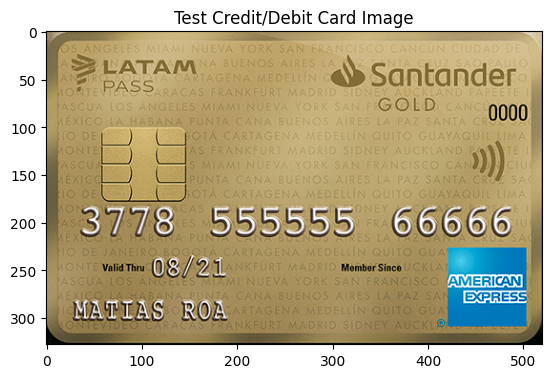

In [410]:
img = cv2.imread(filename=IMAGE_PATH)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show test image
show(img=img_rgb, 
     title="Test Credit/Debit Card Image")

### **SECOND STEP - LOAD MODEL**

In this step, load the fine-tunned **YOLOv10** model to made inferences in the nexts steps with the test images.

First, need to define if the inference will run in **"cpu"** or in **"gpu"** or **"mps"** (for Apple Silicon)

To set in our model instance the way in what must to running the inferences, valid the **"cuda"** status with PyTorch in a new variable to set then in our model.

In [376]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Instance our YOLO model

In [377]:
# Load card detector model
CARD_DETECTOR_DIR = os.getenv("YOLO_CARD_DETECTOR")
card_detector = YOLO(model=CARD_DETECTOR_DIR)
card_detector

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### **THIRD STEP - MAKE INFERENCE OVER A TEST IMAGE**

Now in that step, we are going to make the inference on our test image and show the results


0: 416x640 1 credit_card, 93.2ms
Speed: 3.2ms preprocess, 93.2ms inference, 0.1ms postprocess per image at shape (1, 3, 416, 640)


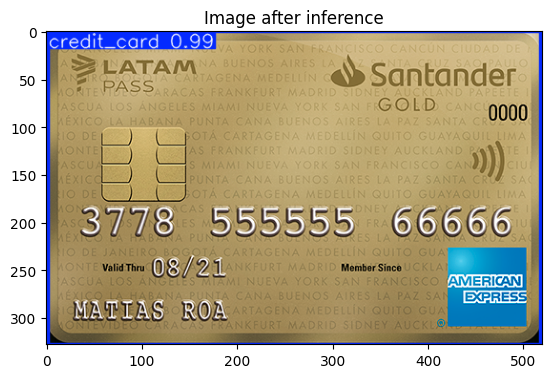

In [415]:
result = card_detector(source=img)

# Show the result
show(img=cv2.cvtColor(result[0].plot(), cv2.COLOR_BGR2RGB),
     title="Image after inference")

### **FOUR STEP - CUT OUT THE CARD FROM THE IMAGE**

In our business an image is valid if our model detect only one card, otherwise the input image is not valid

Credit card box -> [2, 0, 518, 328]
Class -> 0.0


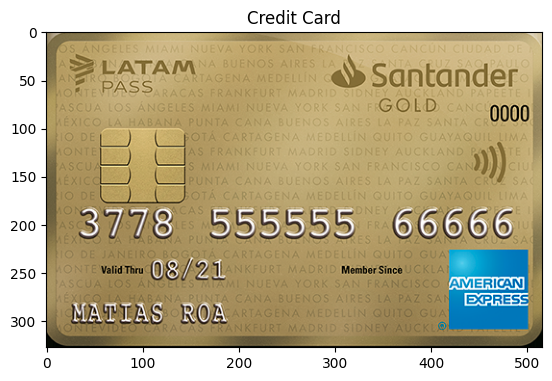

In [416]:
# Validate if the model detected only one credit/debit card, else the image is not valid
xyxy = result[0].boxes.xyxy.cpu()
clss = result[0].boxes.cls.cpu()
confs = result[0].boxes.conf.cpu()

# Apply NMS
filtered_id_boxes = tv.ops.nms(boxes=xyxy, scores=confs, iou_threshold=0.5)

# Select and convert the filtered bounding boxes to a list
xyxy = xyxy[filtered_id_boxes].tolist()
# Select and convert the filtered class labels to a list
clss = clss[filtered_id_boxes].tolist()

if len(xyxy) == 1:
    # Cast to int the coordinates
    xyxy = [int(coord) for coord in xyxy[0]]
    print(f"Credit card box -> {xyxy}\nClass -> {clss[0]}")
    credit_card = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]
    credit_card = cv2.cvtColor(credit_card, cv2.COLOR_BGR2RGB)
    show(img=credit_card,
         title="Credit Card")
else: 
    print("Image not valid!")

### **FIVE STEP - SHOW RESULTS**

Show the results, now we are showing the original image, annotated image and the cut of credit card

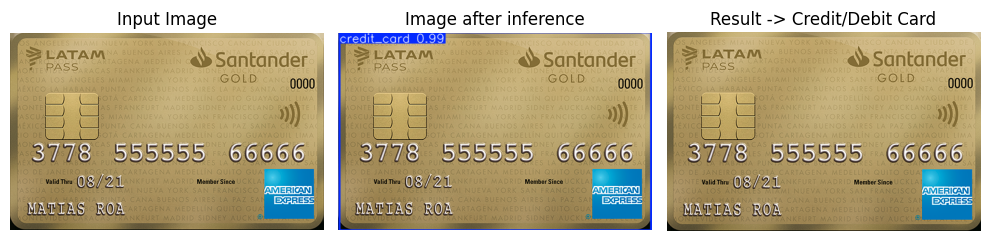

In [418]:
images = [img_rgb, cv2.cvtColor(result[0].plot(), cv2.COLOR_BGR2RGB), credit_card]
labels = ["Input Image", "Image after inference", "Result -> Credit/Debit Card"]

# plt.show()
plot_images(images=images, labels=labels)

## **ENDS THE FIRST STAGE**

With this, it ends the first stage of this process with the cutting of the credit card by `YOLOv10` model, which it is a AI model used to object segmentation, classification and detections in images.

## **SECOND STAGE**

In this stage, we will detect the different elements of credit/debit card using a second fine-tunned **YOLOv10** model, called in this context as `YOLOv10n_CreditCardElementsDetector`.

So we must load the model and detect the card elements!

<div style="text-align: center;">
    <img src="./assets/stage2.png" alt="Texto alternativo" style="border-radius: 15px; width: 400px; margin: 20px;"/>
</div>

**IMPORTANT**

**The following cells will work as long as a card has been detected in the previous step. Otherwise they will produce an error**

### **FIRST STEP - LOAD MODEL**

**NOTE:**

0: Card Number

1: Expiration date

2: Cardholder

3: Payment Network

In [381]:
# Load elements detector model
CARD_ELEMENTS_DETECTOR_DIR = os.getenv("YOLO_CARD_ELEMENT_DETECTOR")
elements_detector = YOLO(CARD_ELEMENTS_DETECTOR_DIR)
elements_detector

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### **SECOND STEP - DETECT CARD ELEMENTS**

In the follows cells, we will to detect the `Card Number`, `Cardholder`, `Expiration Date` and `Payment Network`


0: 416x640 1 card_number, 1 expiry_date, 1 cardholder, 1 payment_network, 89.1ms
Speed: 10.2ms preprocess, 89.1ms inference, 0.2ms postprocess per image at shape (1, 3, 416, 640)
Boxes
[[418.0495300292969, 223.80699157714844, 503.0685119628906, 312.7105712890625], [29.09059715270996, 179.13931274414062, 487.6466064453125, 217.64077758789062], [25.512893676757812, 279.3580627441406, 189.736083984375, 305.84185791015625], [107.97308349609375, 234.83514404296875, 187.7950897216797, 261.0752868652344]]
Confidences
[3.0, 0.0, 2.0, 1.0]


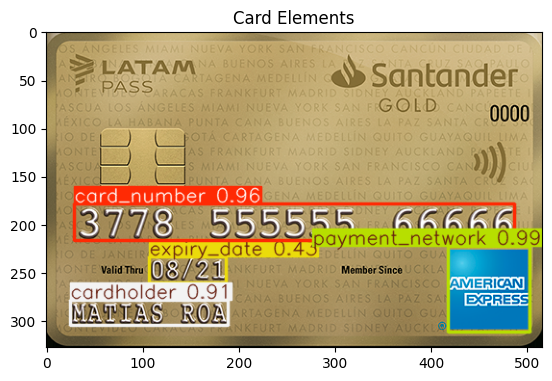

In [420]:
if credit_card is not None:
    result = elements_detector(source=credit_card)
    xyxy = result[0].boxes.xyxy.cpu()
    confs = result[0].boxes.conf.cpu()
    clss = result[0].boxes.cls.cpu()
    
    # Apply NMS
    filtered_id_boxes = tv.ops.nms(boxes=xyxy, scores=confs, iou_threshold=0.5)
    
    # Select and convert the filtered bounding boxes to a list
    xyxy = xyxy[filtered_id_boxes].tolist()
    # Select and convert the filtered class labels to a list
    clss = clss[filtered_id_boxes].tolist()
    
    print(f"Boxes\n{xyxy}")
    print(f"Confidences\n{clss}")
    show(img=result[0].plot(), title="Card Elements")

### **THIRD STEP - CUT OUT CARD ELEMENTS FROM CREDIT CARD**

In [421]:
# Cut the card elements from credit card image
card_number = None
expiry_date = None
cardholder = None
payment_network = None
for box, cls in zip(xyxy, clss):
    # Cast to int the coordinates
    box = [int(coord) for coord in box]
    print(f"Box {box} - cls {cls}")
    if cls == 0.0:
        card_number = credit_card[box[1]:box[3], box[0]:box[2]]
    elif cls == 1.0:
        expiry_date = credit_card[box[1]:box[3], box[0]:box[2]]
    elif cls == 2.0:
        cardholder = credit_card[box[1]:box[3], box[0]:box[2]]
    elif cls == 3.0:
        payment_network = credit_card[box[1]:box[3], box[0]:box[2]]
    else:
        pass

Box [418, 223, 503, 312] - cls 3.0
Box [29, 179, 487, 217] - cls 0.0
Box [25, 279, 189, 305] - cls 2.0
Box [107, 234, 187, 261] - cls 1.0


#### Shows the elements

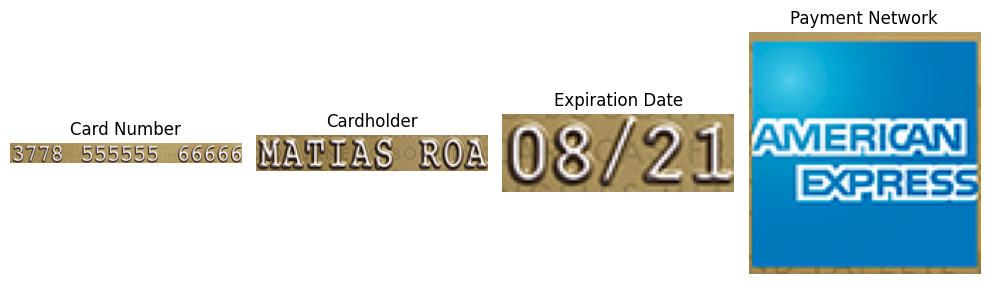

In [422]:
images = [card_number, cardholder, expiry_date, payment_network]
labels = ["Card Number", "Cardholder", "Expiration Date", "Payment Network"]

# plt.show()        
plot_images(images=images, labels=labels)

## **ENDS SECOND STAGE**

Well in this stage, the different elements of the card were detected by `YOLOv10n_CreditCardElementsDetector`, with a great performance and precision. This method solves this task which is more reliable than the method in the previous version, where we define the Payment Network with the use of SIFT algorithm. Because this model is more robust to the variability of changes of the images.

## **THIRD STAGE**

In this stage, we will have different tasks.

In first place, we will classify the Payment Network using a fine-tunned **YOLOv10** classifier model, called in this context as `YOLOv10n_PaymentNetworkClassifier`.

Therefore, to validate this later, it is advisable to use the IIN (Issuer Identification Number) method, which consists of validating the numbers according
to the patterns of each payment entity.

In second place, we get the ROIs, which we use to extract data from credit/debit card, corresponding to the payment network that was defined by our model. In this case we find ourselves in a different situation, since there are cards that do not belong to any payment entity. For example, a well-known case in Argentina is Tarjeta Naranja, which offers its own financial institution card in addition to VISA cards.

In these cases, we define generic ROIs to be able to extract information from it.

Finally, extract the data from credit card. To do this use an **OCR** technique to read the text on an image. There are different libraries to do the **OCR** technique some of them processing in the cloud (e.g **Google Cloud Visio** or **Amazon Textract**) but these libraries aren't free, you need an account and a subscription to get a `API_KEY`  from Google or Amazon.

On the other hand, due to the objectives and scope of this project, in addition to security reasons, it is not advisable to process sensitive information in the cloud.

However, there are some libraries that process it locally (e.g **EasyOCR** or **Tesseract**), in some cases the precision of those packages may be somewhat lower than Google library, but you can have more control about your service.

So in this notebook for this stage, we use a library called **EasyOCR**, which is a **Python** library that use deep learning techniques to do OCR.

* To increase the precision of OCR, make a pre-process in the image previously to make the OCR.


### **FIRST STEP - LOAD CLASSIFICATION MODEL**

Now, load our fine-tunned YOLOv8 classifier.

In [385]:
# Load classification model
PAYMENT_NETWORK_CLASSIFIER = os.getenv("YOLO_PAYMENT_NETWORK_CLASSIFIER")
print(PAYMENT_NETWORK_CLASSIFIER)
classifier = YOLO(PAYMENT_NETWORK_CLASSIFIER)
classifier

/Users/nahueltabasso/Documents/Python/credit-card-project/weights/YOLOv10n-PaymentNetworkClassifier.pt


YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

### **SECOND STEP - DETERMINATE THE PAYMENT NETWORK**

* Check if the payment network was detected in the previous stage
    * If it was not detected, set with a common ROIs
    * If it was detected, classify the payment network


0: 128x128 AmericanExpress 1.00, Mastercard 0.00, VISA 0.00, Cabal 0.00, 4.1ms
Speed: 7.6ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)


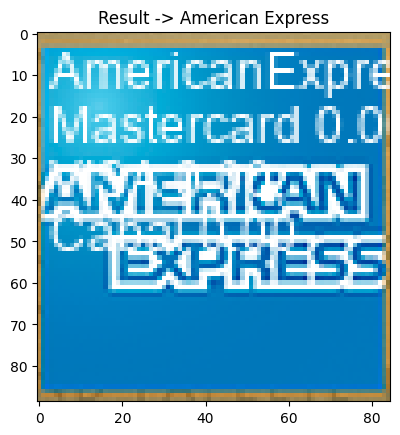

The payment network of our card is American Express


In [386]:
config = Config()
if payment_network is None:
    COMMON_CARD_ZONE = config.COMMON_CARD_ZONES

if payment_network is not None:
    result = classifier(source=payment_network)
    top1 = result[0].probs.top1
    top1_conf = result[0].probs.top1conf
    
    if top1 == 0:
        payment_network_str = "American Express"
    elif top1 == 1:
        payment_network_str = "Cabal"
    elif top1 == 2:
        payment_network_str = "MasterCard"
    elif top1 == 3:
        payment_network_str = "VISA"
    else:
        pass

    plt.imshow(result[0].plot())
    plt.title(f"Result -> {payment_network_str}")
    plt.show()

    print(f"The payment network of our card is {payment_network_str}")

### **THIRD STEP - EXTRACT DATA FROM CARD**

In this step, using an OCR technique with `EasyOCR` extract the data from image.

In [387]:
def preprocess_img(image: np.ndarray, save: bool = False):
    """This function make a pre-process on image: convert to gray scale and 
    increase the contrast and brightness.
    
    Make the follows steps to its pre-process:
    1. Verify that input image be valid
    2. Convert input image to a gray scale
    3. Increase image contrast
    4. Save images to visual inspection

    Args:
        image (np.ndarray): Input image in numpy array format.

    Raises:
        FileNotFoundError: _description_

    Returns:
        _type_: output image in numpy array format
    """
    if image is None:
        raise FileNotFoundError("Imagen no valida")
    
    # Convert img to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Increase constrast and brightness
    contrast = 1.5
    bright = 0
    enhanced = cv2.addWeighted(gray, contrast, gray, 0, bright)

    # Make sure the values are in the range [0, 255]
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    if save:
        cv2.imwrite("./gray.jpg", gray)
        cv2.imwrite("./enhanced.jpg", enhanced)
    return enhanced

def extract_zone(img: np.ndarray, zone: list) -> np.ndarray:
    """Cuts out a zone (bbox) and returns it

    Args:
        img (np.ndarray): opencv image
        zone (list): bbox in format [(x1, y1), (x2, y2)]

    Returns:
        np.ndarray: zone cutted from the image
    """
    p1, p2 = to_fixed(img, zone)
    return img[p1[1]:p2[1], p1[0]:p2[0], ...]

def to_fixed(img: np.ndarray, bbox: tuple) -> tuple:
    """This method convert relatives coords from a bbox to
    absolutes coords

    Args:
        img (np.ndarray): _description_
        bbox (tuple): _description_

    Returns:
        tuple: _description_
    """    
    if len(img.shape) == 3:
        h, w, _ = img.shape
    elif len(img.shape) == 2:
        h, w = img.shape

    relative_bbox = [ (int(b[0]*w), int(b[1]*h)) for b in bbox ]

    return relative_bbox 

**Is recommended to apply a pre-processing on image before to pass by the OCR technique**

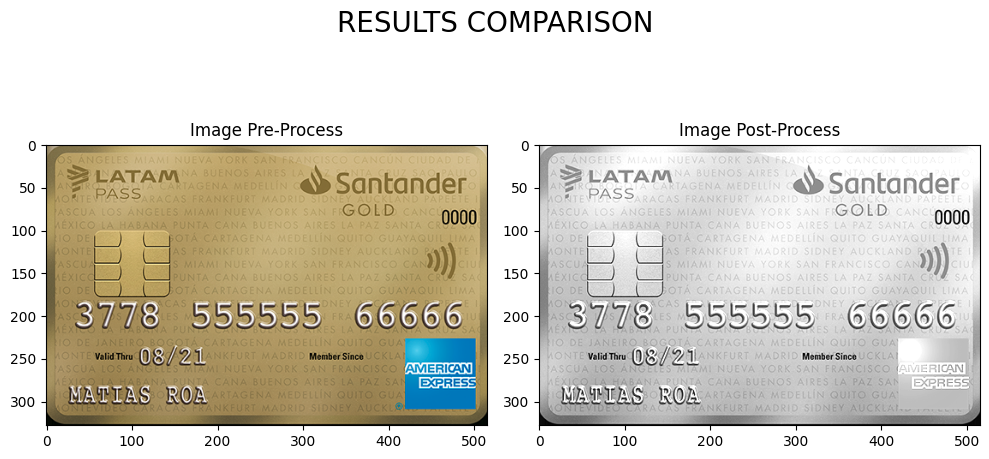

In [388]:
# Apply a pre-processing to the credit card before OCR
credit_card_process = preprocess_img(image=cv2.cvtColor(credit_card, cv2.COLOR_BGR2RGB),
                                     save=True)

credit_card_process_bgr = cv2.cvtColor(credit_card_process,
                                       cv2.COLOR_BGR2RGB)

images = [credit_card, credit_card_process]
labels = ["Image Pre-Process", "Image Post-Process"]

# SHOW RESULTS
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for index, img in enumerate(images):
    # Show each image in subplot
    if index == 1:
        ax[index].imshow(img, cmap='gray')
    else:
        ax[index].imshow(img)
    ax[index].set_title(labels[index])
    
    fig.tight_layout()

fig.suptitle("RESULTS COMPARISON", fontsize=20, y=1.05)
plt.show()

#### Now extract the data with EasyOCR

Extract the Card Number

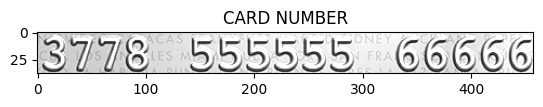

In [389]:
if card_number is not None:
    card_number = preprocess_img(card_number, False)
else:
    card_number = extract_zone(img=credit_card_process,
                               zone=COMMON_CARD_ZONE['card_number'])

plt.imshow(card_number, cmap='gray')
plt.title("CARD NUMBER")
plt.show()

Apply the OCR technique to a `card_number` image

In [390]:
# Create an easyocr instance
reader = easyocr.Reader(['en'])

In [391]:
# Make OCR
results = reader.readtext(card_number)

print(results)
card_number = ""
for (bbox, text, prob) in results:
    card_number += text     

print(f"CARD NUMBER AFTER OCR --- {card_number}")

[([[0, 0], [111, 0], [111, 38], [0, 38]], '3778', 0.9999991059303284), ([[135, 0], [299, 0], [299, 38], [135, 38]], '555555', 0.9999645216238159), ([[324, 0], [458, 0], [458, 38], [324, 38]], '66666', 0.9997495364510179)]
CARD NUMBER AFTER OCR --- 377855555566666


Extract the cardholder

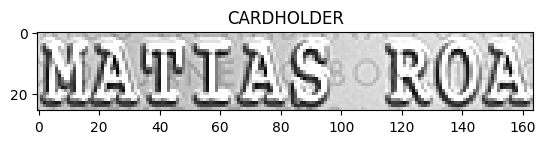

In [392]:
if cardholder is not None:
    cardholder = preprocess_img(cardholder, False)
else:
    cardholder = extract_zone(img=credit_card_process,
                               zone=COMMON_CARD_ZONE['name'])

plt.imshow(cardholder, cmap='gray')
plt.title("CARDHOLDER")
plt.show()

Apply the OCR technique to a `cardholder` image

In [393]:
# Make OCR
results = reader.readtext(cardholder)

print(results)
name = ""
for (bbox, text, prob) in results:
    name += text + " "     

name = name.upper()
print(f"NAME AFTER OCR --- {name}")

[([[0, 0], [164, 0], [164, 26], [0, 26]], 'MAYIAS  ROA', 0.3226243070312705)]
NAME AFTER OCR --- MAYIAS  ROA 


Extract the Expiration Date

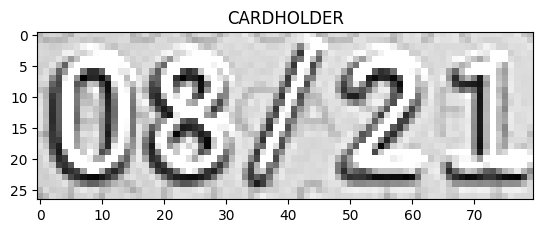

In [394]:
if expiry_date is not None:
    expiry_date = preprocess_img(expiry_date, False)
else:
    expiry_date = extract_zone(img=credit_card_process,
                               zone=COMMON_CARD_ZONE['expiration_date'])

plt.imshow(expiry_date, cmap='gray')
plt.title("CARDHOLDER")
plt.show()

Apply the OCR technique to a `expiry_date` image

In [395]:
# Make OCR
results = reader.readtext(expiry_date)

print(results)
expiration_date = ""
pattern = r'^[0-9/]+$'

for (bbox, text, prob) in results:
    if re.match(pattern, text):
        expiration_date += text     

print(f"EXPIRATION DATE AFTER OCR --- {expiration_date}")

[([[0, 0], [80, 0], [80, 27], [0, 27]], '08/21', 0.43774214046745896)]
EXPIRATION DATE AFTER OCR --- 08/21


### **FOUR STEP - SHOW DATA**

Show the results

In [396]:
print(f"PAYMENT NETWORK --- {payment_network_str}")
print(f"CARD NUMBER --- {card_number}")
print(f"NAME --- {name}")
print(f"EXPIRATION DATE --- {expiration_date}")

PAYMENT NETWORK --- American Express
CARD NUMBER --- 377855555566666
NAME --- MAYIAS  ROA 
EXPIRATION DATE --- 08/21


## **END**

At this stage, the process of this service ends represented in a Jupyter Notebook only with visual purposes of explaining step by step the method to detect a credit/debit card with a fine-tunned **YOLOv10** model. The process for detecting the elements of the card and how to classify the payment network of the card is also shown.

Finally this notebook shows how to extract data from images through **OCR**

#### **NOTES**
* To test this service using a dynamic graphical process, run in a terminal the following command:
```bash
python gradio_ui_app.py
```

This command will set up a Gradio server and return the url to be able to access the Gradio Interface and be able to use the app.

* To test this service through API in /src/api/ run the following command:
```bash
python main.py
```

This command will set up a server. After this, you can access to http://localhost:8000/docs to enter in Swagger and test the different APIs
